<a href="https://colab.research.google.com/github/maquico/IA-IDS330/blob/main/ids330l_semana08_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDS330 | Redes Recurrentes

In [ ]:
import torch

En Pytorch, las capas de RNN se definen con el paquete `torch.nn.RNN`.

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

**Parametros**
* input_size: el numero de features en la entrada x
* hidden_size: la dimension del estado oculto *h*
* num_layers: numero de capas recurrentes
* bidirectional: (bool) si `True`, la red es bidirectional
* batch_first; (bool) si `True`, el input y el output tendran una dimension `(batch_size, seq_len, feature_size)`

**Input**
* input: dimension de `(batch_size, seq_len, feature_size)`, si `batch_first = True`
* h0: tensor que contiene el estado oculto inicial. Su dimension es de `(num_layers * num_directions, batch_size, hidden_size)`

**Output**
* output: tensor que contiene los *features* de la ultima capa de la RNN. Tiene dimension de `(batch_size, seq_len, feature_size)`, si `batch_first = True`
* hn: tensor que contiene el estado oculto final. Su dimension es de `(num_layers * num_directions, batch_size, hidden_size)`

In [ ]:
## RNN de una sola capa
# input_size = 5
# seq_len = 10
# hidden_size = 2

x = torch.rand(1, 10, 5)  # (batch_size, seq_len, feature_size)
h0 = torch.rand(1, 1, 2)
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=1, bidirectional=False, batch_first=True)
output, h_n = rnn(x, h0)


In [ ]:
## RNN de una sola capa
# num_layers = 2
# bidirectional = True
# input_size = 5
# seq_len = 10
# hidden_size = 2

x = torch.rand(1, 10, 5)  # (batch_size, seq_len, feature_size)
h0 = torch.rand(2*2, 1, 2)
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=2, bidirectional=True, batch_first=True)
output, h_n = rnn(x, h0)

## Descargar la data

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("5cp/imdb_review_prompts", trust_remote_code=True)

In [ ]:
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

In [ ]:
train_texts = [text.split('###')[2].replace('Review: ', '') for text in train_texts]
test_texts = [text.split('###')[2].replace('Review: ', '') for text in test_texts]


## Preprocesamiento

In [ ]:
from string import punctuation
from collections import Counter
import numpy as np



train_reviews = [review.lower() for review in train_texts]
test_reviews = [review.lower() for review in test_texts]
train_reviews = [''.join([c for c in review if c not in punctuation]) for review in train_reviews]
test_reviews = [''.join([c for c in review if c not in punctuation]) for review in test_reviews]

all_texts = ' '.join(train_reviews + test_reviews)
words = all_texts.split()
count_words = Counter(words)
sorted_words = count_words.most_common(len(words))
vocab_to_int = {word:i+1 for i, (word,c) in enumerate(sorted_words)}



In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_reviews_int = []
for review in train_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    train_reviews_int.append(r)

test_reviews_int = []
for review in test_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    test_reviews_int.append(r)


In [ ]:
def pad_sequence(reviews_int: list, seq_len: int) -> np.array:

    features = np.zeros((len(reviews_int), seq_len), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_len:
            zeroes = list(np.zeros(seq_len - review_len))
            new_review = zeroes + review
        else:
            new_review = review[:seq_len]
        features[i,:] = np.array(new_review)

    return features


In [ ]:
padded_train_reviews = pad_sequence(train_reviews_int, 100)
padded_test_reviews = pad_sequence(test_reviews_int, 100)

## Cargar como Dataset

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_data = TensorDataset(torch.from_numpy(padded_train_reviews), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(padded_test_reviews), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



In [ ]:
# Check the data
batch = next(iter(train_loader))
x, y = batch

print("Input size:", x.size())
print("Input:", x)

print("Output size:", y.size())
print("Output:", y)


Input size: torch.Size([64, 100])
Input: tensor([[   0,    0,    0,  ...,   92,   49,   46],
        [   0,    0,    0,  ...,  139,    2,  178],
        [   0,    0,    0,  ...,   18,   35,  985],
        ...,
        [   0,    0,    0,  ...,   21, 4947, 4948],
        [   0,    0,    0,  ...,  289,   17,  497],
        [   0,    0,    0,  ..., 5382,   43, 5383]])
Output size: torch.Size([64])
Output: tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1])


## Definir Red Recurrente

In [ ]:
torch.nn.LSTM(x, (h0, c0))

In [ ]:
class SentimentAnalysis(torch.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, output_size: int, hidden_dim: int, num_layers: int):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.embedding = torch.nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx = 0)

        self.rnn = torch.nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, h0):
        embeddings = self.embedding(x)
        output, h_n = self.rnn(embeddings, h0)
        output = self.linear(output[:,-1,:])
        output = self.sigmoid(output)
        return output



## Entrenamiento

In [ ]:
vocab_size = len(vocab_to_int) + 1   # +1 por el padding '0'
output_size = 1

### PUEDEN CAMBIAR ###
embedding_dim = 100
hidden_dim = 128
num_layers = 1
######################

model = SentimentAnalysis(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_size=output_size,
    hidden_dim=hidden_dim,
    num_layers=num_layers)

learning_rate = 0.01
num_epochs = 10

loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.cuda()

losses = []
accuracies = []
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        batch_size = inputs.size(0)
        h0 = torch.randn(num_layers*1, batch_size, hidden_dim)
        h0 = h0.cuda()

        outputs = model(inputs, h0)

        loss = loss_function(outputs.squeeze(), labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = (outputs.squeeze() > 0.5).float()
        acc = torch.mean((pred == labels).float())

        losses.append(loss.item())
        accuracies.append(acc.item())



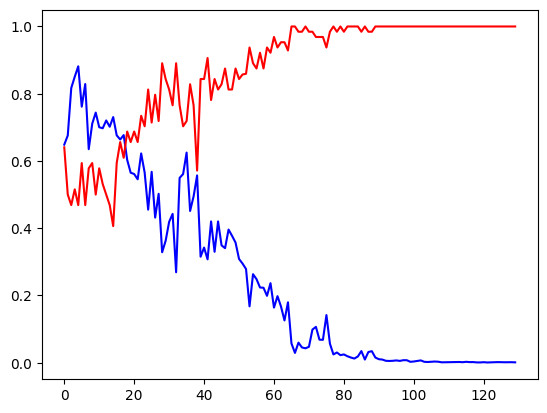

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, 'b')
plt.plot(accuracies, 'r')
plt.show()

In [ ]:
model.eval()
accuracy = 0
total_inputs = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        batch_size = inputs.size(0)
        h0 = torch.randn(num_layers*1, batch_size, hidden_dim)
        h0 = h0.cuda()

        outputs = model(inputs, h0)

        pred = (outputs.squeeze() > 0.5).float()
        acc = torch.sum((pred == labels).float())
        total_inputs += inputs.size(0)
        accuracy += acc.item()

print(f"Accuracy: {100*accuracy/total_inputs:.2f}%")

Accuracy: 60.49%


In [ ]:
import random

def int_to_voc(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
model.cpu()
review, label = random.choice(train_data)
review_sentence = ' '.join([int_to_voc(r, vocab_to_int) for r in review if r != 0])
print(review_sentence)

print("Actual label:", 'negative' if label.item() == 0 else 'positive')

h0 = torch.randn(num_layers*1, 1, hidden_dim)
output = model(review.unsqueeze(0), h0)
sentiment = 'negative' if output <= 0.5 else 'positive'
print("Pred Sentiment:", sentiment)



i was particularly moved by the understated courage and integrity of langlaise in this beautifully acted intellectually and visually compelling film thank you so much monsieur le directeur rohmer
Actual label: positive
Pred Sentiment: positive
